Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [ ]:
! pip install datasets
! pip install transformers

For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Reusing dataset yahoo_answers_topics (C:\Users\Pablo\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)
100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


In [4]:
import torch
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print("GPU")
else:
  device = torch.device('cpu')
  print("CPU")

GPU


# Fine-tuning the model** (20 points)

In [5]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric

import numpy as np


Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


# Mask

In [29]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [7]:
fill_mask = pipeline(
    "fill-mask",
    model = MODEL_NAME,
    tokenizer = TOKENIZER_NAME
)

In [8]:
print("Why don't you ask ...")
print(
    fill_mask(f"Why don't you ask [MASK]?")
)
print('What is ...')

print(
    fill_mask(f"What is [MASK]")
)
print("Let's talk about ... physics")
print(
    fill_mask(f"Let's talk about [MASK] physics")
)

Why don't you ask ...
[{'score': 0.5343003273010254, 'token': 2033, 'token_str': 'me', 'sequence': "why don't you ask me?"}, {'score': 0.08195988088846207, 'token': 3980, 'token_str': 'questions', 'sequence': "why don't you ask questions?"}, {'score': 0.04395342618227005, 'token': 2068, 'token_str': 'them', 'sequence': "why don't you ask them?"}, {'score': 0.04017246887087822, 'token': 2339, 'token_str': 'why', 'sequence': "why don't you ask why?"}, {'score': 0.030024327337741852, 'token': 4426, 'token_str': 'yourself', 'sequence': "why don't you ask yourself?"}]
What is ...
[{'score': 0.9262325167655945, 'token': 1029, 'token_str': '?', 'sequence': 'what is?'}, {'score': 0.051567330956459045, 'token': 1012, 'token_str': '.', 'sequence': 'what is.'}, {'score': 0.021510610356926918, 'token': 999, 'token_str': '!', 'sequence': 'what is!'}, {'score': 0.00011964981240453199, 'token': 1011, 'token_str': '-', 'sequence': 'what is -'}, {'score': 0.00010928380652330816, 'token': 1000, 'token_s

# Fune-Tuning

In [9]:
torch.cuda.empty_cache()

In [10]:
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)

In [11]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\Pablo\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-c1326febfdc99d46.arrow
Loading cached processed dataset at C:\Users\Pablo\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-12931a763309e28e.arrow


In [12]:
tokenized_datasets['train'].features

{'id': Value(dtype='int32', id=None),
 'topic': ClassLabel(num_classes=10, names=['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference', 'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music', 'Family & Relationships', 'Politics & Government'], id=None),
 'question_title': Value(dtype='string', id=None),
 'question_content': Value(dtype='string', id=None),
 'best_answer': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [13]:
tokenized_datasets = tokenized_datasets.remove_columns(["id",'question_title', 'question_content','best_answer' ])
tokenized_datasets = tokenized_datasets.rename_column("topic", "labels")
tokenized_datasets.set_format("torch")

In [14]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10000))

Loading cached shuffled indices for dataset at C:\Users\Pablo\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-5f986a6865073935.arrow
Loading cached shuffled indices for dataset at C:\Users\Pablo\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-d68eb813e9a4c3a7.arrow


In [15]:
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [16]:
model_cl = ElectraForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=10)


Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.weight', 'generator_lm_head.bias', 'generator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [17]:
from torch.optim import AdamW

optimizer = AdamW(model_cl.parameters(), lr=5e-5)

In [18]:

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [19]:
torch.cuda.is_available()

True

In [20]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_cl.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [21]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
loss_list = []
loss_epoch= []
model_cl.train()
for epoch in range(num_epochs):
    loss_temp = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_cl(**batch)
        loss = outputs.loss
        loss_list.append(loss.item())
        loss_temp.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    loss_epoch.append(np.mean(loss_temp))

100%|██████████| 12500/12500 [35:23<00:00,  5.69it/s]

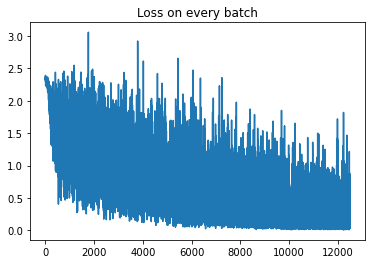

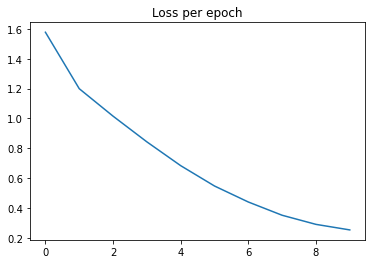

In [68]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.title("Loss on every batch")
plt.show()
plt.plot(loss_epoch)
plt.title("Loss per epoch")
plt.show()

In [23]:
from sklearn.metrics import f1_score

In [24]:
metric_f1 = load_metric('f1')
metric_accuracy = load_metric('accuracy')
model_cl.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_cl(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric_f1.add_batch(predictions=predictions, references=batch["labels"])
    metric_accuracy.add_batch(predictions=predictions, references=batch["labels"])

print(metric_f1.compute(average = 'weighted'))
print(metric_accuracy.compute())

Using the latest cached version of the module from C:\Users\Pablo\.cache\huggingface\modules\datasets_modules\metrics\f1\4f006eef192effdc533301c01aff7e4922b5a427fbdf53c50b3db69887dbdada (last modified on Sun Mar 27 17:12:59 2022) since it couldn't be found locally at f1, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\Pablo\.cache\huggingface\modules\datasets_modules\metrics\accuracy\bbddc2dafac9b46b0aeeb39c145af710c55e03b223eae89dfe86388f40d9d157 (last modified on Mon Mar 28 00:39:50 2022) since it couldn't be found locally at accuracy, or remotely on the Hugging Face Hub.


{'f1': 0.5532008915231836}
{'accuracy': 0.5534}


In [25]:
model_cl.save_pretrained('D:\\Documents\\ITMO\\Year1\\NLP\\Hw4\\model_cl')


## Mask with fine-tuned

In [26]:
model_tuned = ElectraForMaskedLM.from_pretrained('D:\\Documents\\ITMO\\Year1\\NLP\\Hw4\\model_cl')

Some weights of the model checkpoint at D:\Documents\ITMO\Year1\NLP\Hw4\model_cl were not used when initializing ElectraForMaskedLM: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at D:\Documents\ITMO\Year1\NLP\Hw4\model_cl and are newly initialized: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_prediction

In [32]:
fill_mask2 = pipeline(
    "fill-mask",
    model = model_tuned,
    tokenizer = TOKENIZER_NAME
)

In [33]:
#previous results
print("Why don't you ask ...")
print(
    fill_mask(f"Why don't you ask [MASK]?")
)
print('What is ...')

print(
    fill_mask(f"What is [MASK]")
)
print("Let's talk about ... physics")
print(
    fill_mask(f"Let's talk about [MASK] physics")
)

Why don't you ask ...
[{'score': 0.5343003273010254, 'token': 2033, 'token_str': 'me', 'sequence': "why don't you ask me?"}, {'score': 0.08195988088846207, 'token': 3980, 'token_str': 'questions', 'sequence': "why don't you ask questions?"}, {'score': 0.04395342618227005, 'token': 2068, 'token_str': 'them', 'sequence': "why don't you ask them?"}, {'score': 0.04017246887087822, 'token': 2339, 'token_str': 'why', 'sequence': "why don't you ask why?"}, {'score': 0.030024327337741852, 'token': 4426, 'token_str': 'yourself', 'sequence': "why don't you ask yourself?"}]
What is ...
[{'score': 0.9262325167655945, 'token': 1029, 'token_str': '?', 'sequence': 'what is?'}, {'score': 0.051567330956459045, 'token': 1012, 'token_str': '.', 'sequence': 'what is.'}, {'score': 0.021510610356926918, 'token': 999, 'token_str': '!', 'sequence': 'what is!'}, {'score': 0.00011964981240453199, 'token': 1011, 'token_str': '-', 'sequence': 'what is -'}, {'score': 0.00010928380652330816, 'token': 1000, 'token_s

In [34]:
#new results
print("Why don't you ask ...")
print(
    fill_mask2(f"Why don't you ask [MASK]?")
)
print('What is ...')

print(
    fill_mask2(f"What is [MASK]")
)
print("Let's talk about ... physics")
print(
    fill_mask2(f"Let's talk about [MASK] physics")
)

Why don't you ask ...
[{'score': 0.00034672103356570005, 'token': 20139, 'token_str': 'koppen', 'sequence': "why don't you ask koppen?"}, {'score': 0.00029287641518749297, 'token': 15982, 'token_str': 'demographic', 'sequence': "why don't you ask demographic?"}, {'score': 0.00027616581064648926, 'token': 22865, 'token_str': 'catchment', 'sequence': "why don't you ask catchment?"}, {'score': 0.0002563123998697847, 'token': 22525, 'token_str': 'nair', 'sequence': "why don't you ask nair?"}, {'score': 0.000251687626587227, 'token': 7778, 'token_str': 'statistical', 'sequence': "why don't you ask statistical?"}]
What is ...
[{'score': 0.0003010255459230393, 'token': 3726, 'token_str': '##ve', 'sequence': 'what isve'}, {'score': 0.00029521051328629255, 'token': 26513, 'token_str': 'reused', 'sequence': 'what is reused'}, {'score': 0.00027086990303359926, 'token': 23148, 'token_str': 'hodge', 'sequence': 'what is hodge'}, {'score': 0.0002680025645531714, 'token': 18973, 'token_str': 'avalon'

## Not updating initial weights

In [35]:
model_cl2 = ElectraForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=10)


Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.weight', 'generator_lm_head.bias', 'generator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [36]:
for param in model_cl2.electra.parameters():
      param.requires_grad = False

In [37]:
from torch.optim import AdamW
optimizer = AdamW(model_cl2.parameters(), lr=5e-5)

In [38]:

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_cl2.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [39]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
loss_list2 = []
loss_epoch2= []
model_cl2.train()
for epoch in range(num_epochs):
    loss_temp = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_cl2(**batch)
        loss = outputs.loss
        loss_list2.append(loss.item())
        loss_temp.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    loss_epoch2.append(np.mean(loss_temp))

100%|██████████| 12500/12500 [47:11<00:00,  4.41it/s]


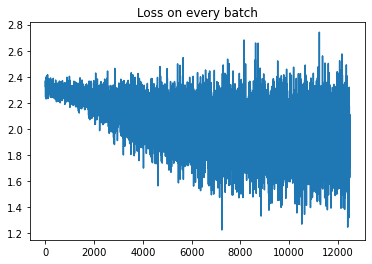

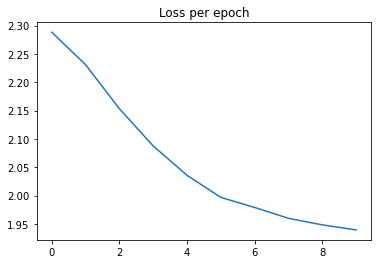

In [67]:
import matplotlib.pyplot as plt

plt.plot(loss_list2)
plt.title("Loss on every batch")
plt.show()
plt.plot(loss_epoch2)
plt.title("Loss per epoch")
plt.show()

In [41]:
acc = load_metric('accuracy')
f1 = load_metric('f1')
model_cl2.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_cl2(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    acc.add_batch(predictions=predictions, references=batch["labels"])
    f1.add_batch(predictions=predictions, references=batch["labels"])

print(acc.compute())
print(f1.compute(average = 'weighted'))

{'accuracy': 0.4266}
{'f1': 0.39265319080567507}


In [45]:
model_cl2.save_pretrained('D:\\Documents\\ITMO\\Year1\\NLP\\Hw4\\model_cl2')


In [63]:

model_tuned_nu = ElectraForMaskedLM.from_pretrained('D:\\Documents\\ITMO\\Year1\\NLP\\Hw4\\model_cl2')
fill_mask_nu = pipeline(
    "fill-mask",
    model = model_tuned_nu,
    tokenizer = TOKENIZER_NAME
)



Some weights of the model checkpoint at D:\Documents\ITMO\Year1\NLP\Hw4\model_cl2 were not used when initializing ElectraForMaskedLM: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at D:\Documents\ITMO\Year1\NLP\Hw4\model_cl2 and are newly initialized: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_predicti

In [64]:
print("Why don't you ask ...")
print(
    fill_mask_nu(f"Why don't you ask [MASK]?")
)
print('What is ...')

print(
    fill_mask_nu(f"What is [MASK]")
)
print("Let's talk about ... physics")
print(
    fill_mask_nu(f"Let's talk about [MASK] physics")
)

Why don't you ask ...
[{'score': 0.00032294256379827857, 'token': 24549, 'token_str': 'canning', 'sequence': "why don't you ask canning?"}, {'score': 0.0003023431054316461, 'token': 7765, 'token_str': 'brushed', 'sequence': "why don't you ask brushed?"}, {'score': 0.0002671909751370549, 'token': 12766, 'token_str': 'brushing', 'sequence': "why don't you ask brushing?"}, {'score': 0.0002584590984042734, 'token': 16546, 'token_str': 'cooke', 'sequence': "why don't you ask cooke?"}, {'score': 0.00024333936744369566, 'token': 9640, 'token_str': 'batting', 'sequence': "why don't you ask batting?"}]
What is ...
[{'score': 0.00024414234212599695, 'token': 22432, 'token_str': 'mca', 'sequence': 'what is mca'}, {'score': 0.00023318947933148593, 'token': 21223, 'token_str': '##oration', 'sequence': 'what isoration'}, {'score': 0.0002287246024934575, 'token': 26098, 'token_str': 'knitting', 'sequence': 'what is knitting'}, {'score': 0.00022829626686871052, 'token': 3752, 'token_str': 'reading', '

## Hyperparameters tuning

In [59]:
model_cl_hyp = ElectraForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=10)

for param in model_cl_hyp.electra.parameters():
      param.requires_grad = False


from torch.optim import AdamW
optimizer = AdamW(model_cl_hyp.parameters(), lr=0.001, eps=1e-09, weight_decay=0.0005)

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_cl_hyp.to(device)


Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.weight', 'generator_lm_head.bias', 'generator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [60]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
loss_list_hyp = []
loss_epoch_hyp = []
model_cl_hyp.train()
for epoch in range(num_epochs):
    loss_temp = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_cl_hyp(**batch)
        loss = outputs.loss
        loss_list_hyp.append(loss.item())
        loss_temp.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    loss_epoch_hyp.append(np.mean(loss_temp))
import matplotlib.pyplot as plt



100%|██████████| 12500/12500 [15:25<00:00, 13.72it/s]

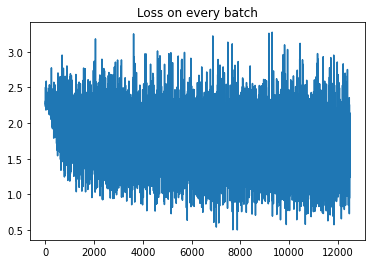

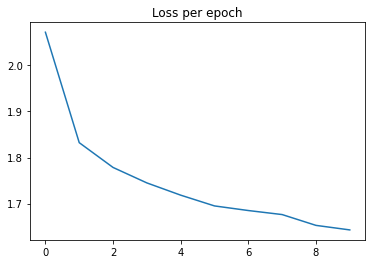

In [61]:
plt.plot(loss_list_hyp)
plt.title("Loss on every batch")
plt.show()

plt.plot(loss_epoch_hyp)
plt.title("Loss per epoch")
plt.show()

In [62]:
acc = load_metric('accuracy')
f1 = load_metric('f1')
model_cl_hyp.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model_cl_hyp(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    acc.add_batch(predictions=predictions, references=batch["labels"])
    f1.add_batch(predictions=predictions, references=batch["labels"])

print(acc.compute())
print(f1.compute(average = 'weighted'))

{'accuracy': 0.5061}
{'f1': 0.4985540823899093}


With the higher value of learning rate the accuracy and f1 were very low (0.0981 and 0.01752774792823969 respectively). I've tried different params but did not succeed to overcome the accuracy of 60%. It was with another parameters which unfortunately was lost... I think my pc will die if I'll take bigger samples and will run more models...

In [65]:
model_cl_hyp.save_pretrained('D:\\Documents\\ITMO\\Year1\\NLP\\Hw4\\model_cl_hyp')


model_tuned_hyp = ElectraForMaskedLM.from_pretrained('D:\\Documents\\ITMO\\Year1\\NLP\\Hw4\\model_cl_hyp')
fill_mask_hyp = pipeline(
    "fill-mask",
    model = model_tuned_hyp,
    tokenizer = TOKENIZER_NAME
)

Some weights of the model checkpoint at D:\Documents\ITMO\Year1\NLP\Hw4\model_cl_hyp were not used when initializing ElectraForMaskedLM: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at D:\Documents\ITMO\Year1\NLP\Hw4\model_cl_hyp and are newly initialized: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_pr

In [66]:
print("Why don't you ask ...")
print(
    fill_mask_hyp(f"Why don't you ask [MASK]?")
)
print('What is ...')

print(
    fill_mask_hyp(f"What is [MASK]")
)
print("Let's talk about ... physics")
print(
    fill_mask_hyp(f"Let's talk about [MASK] physics")
)

Why don't you ask ...
[{'score': 0.0004459815681912005, 'token': 5827, 'token_str': 'credited', 'sequence': "why don't you ask credited?"}, {'score': 0.00037547704414464533, 'token': 18764, 'token_str': 'shuffled', 'sequence': "why don't you ask shuffled?"}, {'score': 0.0003570921253412962, 'token': 24452, 'token_str': 'swiped', 'sequence': "why don't you ask swiped?"}, {'score': 0.00028415845008566976, 'token': 21839, 'token_str': 'filtered', 'sequence': "why don't you ask filtered?"}, {'score': 0.0002683201455511153, 'token': 19538, 'token_str': 'minh', 'sequence': "why don't you ask minh?"}]
What is ...
[{'score': 0.0005457609076984227, 'token': 10688, 'token_str': 'speedway', 'sequence': 'what is speedway'}, {'score': 0.0004472695873118937, 'token': 24822, 'token_str': 'republics', 'sequence': 'what is republics'}, {'score': 0.00038658984703943133, 'token': 24671, 'token_str': 'jimmie', 'sequence': 'what is jimmie'}, {'score': 0.000345398613717407, 'token': 15503, 'token_str': 'zhu